Importing module

In [1]:
from __future__ import print_function

import csv
from os import listdir
import numpy as np
import tensorflow as tf

from math import tan, atan, sqrt, pow, floor
from itertools import product
from matplotlib import pyplot as plt
plt.style.use('ggplot')

from random import shuffle
from keras import Input, Model
from keras.callbacks import LearningRateScheduler
from keras.initializers import RandomNormal
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, CuDNNLSTM, Reshape
from keras.regularizers import l1, l2
from keras.optimizers import Adam

Using TensorFlow backend.


Mounting google drive

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


Loading data matrix (joints)

In [0]:
PATH_NPY = "/content/gdrive/My Drive/Gym_trainer/openpose/output/"

npy_files = listdir(PATH_NPY)
npy_files.sort()
x_data = []
for files in npy_files:
  x_data.append(np.load(PATH_NPY + files))

Loading score vector

In [0]:
PATH_SCORE = "/content/gdrive/My Drive/Gym_trainer/openpose/"

y_data = []
with open(PATH_SCORE + "New.csv") as csv_file:
  csv_reader = csv.reader(csv_file)
  for row in csv_reader:
    y_data.append(float(row[1]))

Changing shape

In [0]:
z = []
for x in x_data:
  temp = np.concatenate((x[0,:,:],x[1,:,:]), axis=1)
  z.append(temp)

x_data = z

Max_size function

In [0]:
def maximum_size(data, axis):
  max_size = 0
  for x in x_data:
    size = x.shape[axis]
    if size >= max_size:
      max_size = size
  return max_size

Padding function

In [0]:
def pad(data, max_size):
  data_pad = []
  first_shape, _, last_shape = data[0].shape
  for x in data:
    x_zeros = np.zeros((first_shape, max_size - x.shape[1], last_shape))
    new_x = np.append(x, x_zeros, axis = 1)
    data_pad.append(new_x)
  return data_pad

New pad

In [0]:
def new_pad(data, max_size):
  data_pad = []
  last_shape = data[0].shape[1]
  for x in data:
    x_zeros = np.zeros((max_size - x.shape[0], last_shape))
    new_x = np.append(x, x_zeros, axis = 0)
    data_pad.append(new_x)
  return data_pad

Standardize

In [0]:
#retrancher distance à 8 puis divisier par la norme

def standardize(data):
  new_data = data
  nb_joints = data[0].shape[2]
  for i in range(len(data)):
    for j in range(data[i].shape[1]):
      x_center = data[i][0,j,8]
      y_center = data[i][1,j,8]
      for k in range(nb_joints):
        if k == 8:
          new_data[i][0,j,k] = 0
          new_data[i][1,j,k] = 0
        else:
          norm_sq = (data[i][0,j,k] - x_center)**2 + (data[i][1,j,k] - y_center)**2
          # print(norm_sq, i, j, k, data[i][0,j,k])
          new_data[i][0,j,k] = (data[i][0,j,k] - x_center)**2 / norm_sq
          new_data[i][1,j,k] = (data[i][1,j,k] - y_center)**2 / norm_sq
  return new_data

New standardize

In [0]:
#retrancher distance à 8 puis divisier par la norme

from math import sqrt

def new_standardize(data):
  new_data = data
  nb_joints = data[0].shape[1]//2
  # each video
  for i in range(len(data)):
    # each frame
    for j in range(data[i].shape[0]):
      # middle of hips
      x_center = data[i][0,8]
      y_center = data[i][1,33]
      norm_sq = sqrt((data[i][j,1])**2 + (data[i][j,26])**2)
      for k in range(nb_joints):
        # each joint
        if k == 8:
          new_data[i][j,8] = 0
          new_data[i][j,33] = 0
        else:
          if norm_sq != 0:
            new_data[i][j,k] = (data[i][j,k] - x_center) / norm_sq
            new_data[i][j,k + 25] = (data[i][j,k + 25] - y_center) / norm_sq
  return new_data

Spliting data

In [0]:
def split_data(x_data, y_data, index):
  x_train = np.array(x_data[0:index], ndmin=2)
  x_test = np.array(x_data[(index + 1):])
  y_train = np.array(y_data[0:index])
  y_test = np.array(y_data[(index + 1):])
  return (x_train, x_test, y_train, y_test)

Sorting videos by size (number of frames)

In [0]:
def sort_by_size(x_data, y_data):
  shapes_index = [(i, x_data[i].shape[0]) for i in range(len(x_data))]
  dtype = [('index', int), ('shape', int)]
  shapes_index = np.array(shapes_index, dtype=dtype)
  shapes_index = np.sort(shapes_index, order='shape')
  x_data = [x_data[i] for i,shape in shapes_index]
  y_data = [y_data[i] for i,shape in shapes_index]
  return x_data

Shuffle

In [0]:
def shuffle_list(*ls):
  l = list(zip(*ls))
  shuffle(l)
  return l

def deshuffle(ls):
  x = []
  y = []
  for (i,j) in ls:
    x.append(i)
    y.append(j)
  return x, y

Processing data

In [0]:
x_data = sort_by_size(x_data, y_data)
x_data = x_data[-84:]
y_data = y_data[-84:]
max_size = maximum_size(x_data, 0)
x_data = new_pad(x_data, max_size)
x_data = new_standardize(x_data)
y_data = [y / 45 for y in y_data]
temp = shuffle_list(x_data, y_data)
x_data, y_data = deshuffle(temp)
index = int(len(x_data)*0.75)
x_train, x_test, y_train, y_test = split_data(x_data, y_data, index)

In [14]:
np.set_printoptions(threshold=np.inf)
print(x_data[-1])

[[ 3.76468025e-03  3.88067519e-03 -6.43295054e-02 -9.09503443e-02
  -9.49186601e-02  8.34622265e-02  1.09925828e-01  9.85725008e-02
   0.00000000e+00 -4.18007102e-02 -4.92114981e-02 -4.93378037e-02
   5.29903555e-02  3.41501994e-02  3.42365512e-02 -3.97218231e-03
   2.64300917e-02 -3.01638400e-02  4.93687357e-02  3.42468619e-02
   6.07285069e-02  2.66955912e-02 -6.45950049e-02 -9.09103905e-02
  -3.41617989e-02 -4.13337661e-01 -2.88302848e-01 -2.88317025e-01
  -1.32855450e-01  1.51798713e-02 -2.88229384e-01 -1.36508002e-01
   1.89574398e-02  0.00000000e+00 -7.47909602e-03  2.27555009e-01
   4.36032716e-01 -4.76868090e-05  2.27547276e-01  4.24783784e-01
  -4.32240970e-01 -4.32360832e-01 -4.05745148e-01 -4.05862432e-01
   5.00577456e-01  4.93042940e-01  4.43621363e-01  4.96820509e-01
   4.81690902e-01  4.47508482e-01]
 [ 8.99463929e-01  8.99582501e-01  8.31372479e-01  8.04825165e-01
   7.93382935e-01  9.79165157e-01  1.00566994e+00  1.00935341e+00
   0.00000000e+00  8.53930865e-01  8.4647

Create model

In [15]:
input_size = x_data[0].shape

def create_model(input_size, first_size, second_size):
  inputs = Input(shape=input_size, name='input')
  lstm_layer = CuDNNLSTM(first_size, kernel_initializer=RandomNormal(mean=0.0, stddev=0.01), kernel_regularizer=l2(0.1))(inputs)
  hidden_layer = Dense(second_size, activation='linear', kernel_initializer=RandomNormal(mean=0.0, stddev=0.01), kernel_regularizer=l2(0.1))(lstm_layer)
  outputs = Dense(1, activation='linear', kernel_initializer=RandomNormal(mean=0.0, stddev=0.01), kernel_regularizer=l2(0.1))(hidden_layer)
  model = Model(inputs, outputs)
  model.summary()
  model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mse'])
  return model

model = create_model(input_size, 1610, 16)




Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 322, 50)           0         
_________________________________________________________________
cu_dnnlstm_1 (CuDNNLSTM)     (None, 1610)              10703280  
_________________________________________________________________
dense_1 (Dense)              (None, 16)                25776     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 17        
Total params: 10,729,073
Trainable params: 10,729,073
Non-trainable params: 0
_________________________________________________________________



Learning rate decay

In [0]:
def step_decay(epoch):
  initial_lrate = 0.001
  drop = 0.5
  epochs_drop = 10.0
  lrate = initial_lrate * pow(drop, floor((1+epoch)/epochs_drop))
  return lrate

In [0]:
def print_history(history):
  """ summarize history for loss"""
  fiq, ax = plt.subplots(figsize=(8,8))
  ax.plot(history.history['loss'])
  ax.plot(history.history['val_loss'])
  ax.set(title='model loss', ylabel='loss', xlabel='epoch')
  ax.legend(['train', 'test'], loc='upper left')
  ax.grid(True, linestyle='-.')
  plt.show()




Train on 63 samples, validate on 20 samples
Epoch 1/100





63/63 [==============================] - 14s 227ms/step - loss: 3.4827 - mean_squared_error: 0.2609 - val_loss: 2.7871 - val_mean_squared_error: 0.2842
Epoch 2/100
63/63 [==============================] - 0s 7ms/step - loss: 2.5136 - mean_squared_error: 0.2043 - val_loss: 1.8832 - val_mean_squared_error: 0.1073
Epoch 3/100
63/63 [==============================] - 0s 7ms/step - loss: 1.7013 - mean_squared_error: 0.0646 - val_loss: 1.2748 - val_mean_squared_error: 0.0204
Epoch 4/100
63/63 [==============================] - 0s 7ms/step - loss: 1.2006 - mean_squared_error: 0.0465 - val_loss: 0.9025 - val_mean_squared_error: 0.0247
Epoch 5/100
63/63 [==============================] - 0s 7ms/step - loss: 0.8502 - mean_squared_error: 0.0440 - val_loss: 0.6353 - val_mean_squared_error: 0.0242
Epoch 6/100
63/63 [==============================] - 0s 7ms/step - loss: 0.5997 - mean_squared_error: 0.0376 - val_loss: 0.4771 - val_mean_s

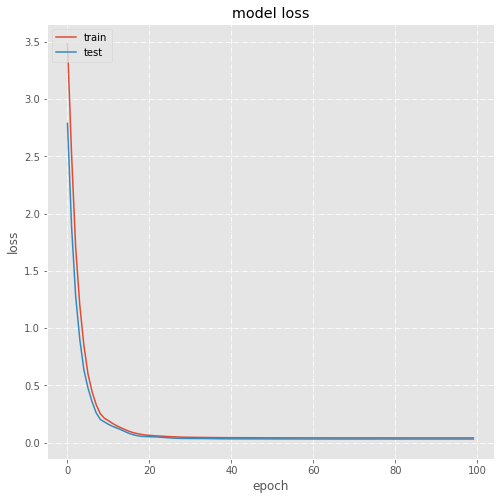

In [18]:
lrate = LearningRateScheduler(step_decay)
history = model.fit(x=x_train, y=y_train, epochs=100, validation_data=(x_test, y_test), callbacks=[lrate], shuffle=False)
print_history(history)

In [0]:
def predict(x_test, y_test):
  """ print prediction on test set"""
  y_prediction = (np.array(model.predict(x_test))).flatten()
  print("Real value | Prediction")
  print("Correlation:")
  print(np.corrcoef(y_test, y_prediction))
  print("Values")
  for (y_predict, y) in zip(y_prediction, y_test):
    print(y, "|", y_predict)
  fiq, ax = plt.subplots(figsize=(8,8))
  ax.scatter(y_test, y_prediction)
  ax.set(title='Correlation', ylabel='predicted y_test', xlabel='real y_test')
  ax.grid(True, linestyle='-.')
  plt.show()

Real value | Prediction
Correlation:
[[ 1. nan]
 [nan nan]]
Values
0.7444444444444445 | 0.46757793
0.4777777777777778 | 0.46757793
0.4777777777777778 | 0.46757793
0.5333333333333333 | 0.46757793
0.6555555555555556 | 0.46757793
0.35555555555555557 | 0.46757793
0.4111111111111111 | 0.46757793
0.6222222222222222 | 0.46757793
0.6333333333333333 | 0.46757793
0.7888888888888889 | 0.46757793
0.5 | 0.46757793
0.7777777777777778 | 0.46757793
0.45555555555555555 | 0.46757793
0.5 | 0.46757793
0.5333333333333333 | 0.46757793
0.4111111111111111 | 0.46757793
0.5555555555555556 | 0.46757793
0.4 | 0.46757793
0.5555555555555556 | 0.46757793
0.23333333333333334 | 0.46757793


/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


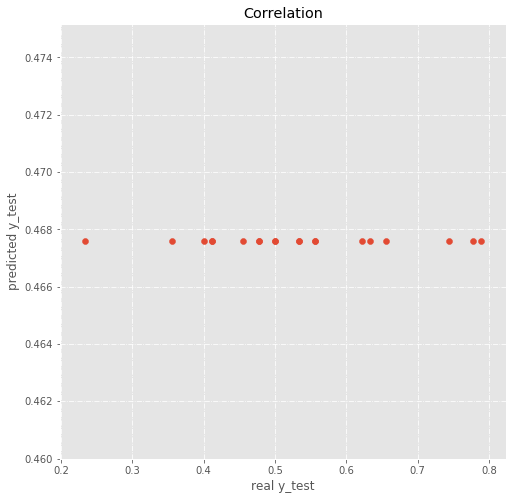

In [20]:
predict(x_test, y_test)

In [0]:
PATH_MODEL = "/content/gdrive/My Drive/Gym_trainer/openpose/model_config"

def for_model(input_size, low_bound, high_bound, low_bound2, high_bound2):
  # layer = list(map(lambda x: int(input_size[0]*input_size[1]//(10*x)), range(low_bound, high_bound)))
  layer = list(map(lambda x: int(pow(2,x)), range(low_bound, high_bound)))
  layer2 = list(map(lambda x: int(pow(2,x)), range(low_bound2, high_bound2)))
  corr_matrix = []
  for (i,j) in product(layer, layer2):
    model = create_model(input_size, i, j)
    lrate = LearningRateScheduler(step_decay)
    history = model.fit(x=x_train, y=y_train, epochs=100, validation_data=(x_test, y_test), callbacks=[lrate], shuffle=False, verbose=0)
    y_prediction = (np.array(model.predict(x_test))).flatten()
    correlation = np.corrcoef(y_test, y_prediction)
    correlation = correlation[0,1]
    print("Dimensions : ",i,"et",j,", correlation :", correlation)
    corr_matrix.append(correlation)
    model.save(PATH_MODEL + "_" + str(i) + "_" + str(j) + '.h5')
  return corr_matrix


In [0]:
input_size = x_data[0].shape
matrix = for_model(input_size, 6,11, 4, 9)

Model: "model_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 322, 50)           0         
_________________________________________________________________
cu_dnnlstm_26 (CuDNNLSTM)    (None, 64)                29696     
_________________________________________________________________
dense_51 (Dense)             (None, 16)                1040      
_________________________________________________________________
dense_52 (Dense)             (None, 1)                 17        
Total params: 30,753
Trainable params: 30,753
Non-trainable params: 0
_________________________________________________________________
Dimensions :  64 et 16 , correlation : 0.13713683254799267
Model: "model_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 322, 50

/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


Dimensions :  128 et 16 , correlation : nan
Model: "model_32"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 322, 50)           0         
_________________________________________________________________
cu_dnnlstm_32 (CuDNNLSTM)    (None, 128)               92160     
_________________________________________________________________
dense_63 (Dense)             (None, 32)                4128      
_________________________________________________________________
dense_64 (Dense)             (None, 1)                 33        
Total params: 96,321
Trainable params: 96,321
Non-trainable params: 0
_________________________________________________________________
Dimensions :  128 et 32 , correlation : 0.16886843545250144
Model: "model_33"
_________________________________________________________________
Layer (type)                 Output Shape              Param #  

/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


Dimensions :  256 et 16 , correlation : nan
Model: "model_37"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 322, 50)           0         
_________________________________________________________________
cu_dnnlstm_37 (CuDNNLSTM)    (None, 256)               315392    
_________________________________________________________________
dense_73 (Dense)             (None, 32)                8224      
_________________________________________________________________
dense_74 (Dense)             (None, 1)                 33        
Total params: 323,649
Trainable params: 323,649
Non-trainable params: 0
_________________________________________________________________


/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


Dimensions :  256 et 32 , correlation : nan
Model: "model_38"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 322, 50)           0         
_________________________________________________________________
cu_dnnlstm_38 (CuDNNLSTM)    (None, 256)               315392    
_________________________________________________________________
dense_75 (Dense)             (None, 64)                16448     
_________________________________________________________________
dense_76 (Dense)             (None, 1)                 65        
Total params: 331,905
Trainable params: 331,905
Non-trainable params: 0
_________________________________________________________________
Dimensions :  256 et 64 , correlation : -0.13468539853374464
Model: "model_39"
_________________________________________________________________
Layer (type)                 Output Shape              Param 

/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


Dimensions :  512 et 16 , correlation : nan
Model: "model_42"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 322, 50)           0         
_________________________________________________________________
cu_dnnlstm_42 (CuDNNLSTM)    (None, 512)               1155072   
_________________________________________________________________
dense_83 (Dense)             (None, 32)                16416     
_________________________________________________________________
dense_84 (Dense)             (None, 1)                 33        
Total params: 1,171,521
Trainable params: 1,171,521
Non-trainable params: 0
_________________________________________________________________


/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


Dimensions :  512 et 32 , correlation : nan
Model: "model_43"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 322, 50)           0         
_________________________________________________________________
cu_dnnlstm_43 (CuDNNLSTM)    (None, 512)               1155072   
_________________________________________________________________
dense_85 (Dense)             (None, 64)                32832     
_________________________________________________________________
dense_86 (Dense)             (None, 1)                 65        
Total params: 1,187,969
Trainable params: 1,187,969
Non-trainable params: 0
_________________________________________________________________
Dimensions :  512 et 64 , correlation : -0.1346853985337447
Model: "model_44"
_________________________________________________________________
Layer (type)                 Output Shape              Par

/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


Dimensions :  1024 et 16 , correlation : nan
Model: "model_47"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 322, 50)           0         
_________________________________________________________________
cu_dnnlstm_47 (CuDNNLSTM)    (None, 1024)              4407296   
_________________________________________________________________
dense_93 (Dense)             (None, 32)                32800     
_________________________________________________________________
dense_94 (Dense)             (None, 1)                 33        
Total params: 4,440,129
Trainable params: 4,440,129
Non-trainable params: 0
_________________________________________________________________


/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


Dimensions :  1024 et 32 , correlation : nan
Model: "model_48"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 322, 50)           0         
_________________________________________________________________
cu_dnnlstm_48 (CuDNNLSTM)    (None, 1024)              4407296   
_________________________________________________________________
dense_95 (Dense)             (None, 64)                65600     
_________________________________________________________________
dense_96 (Dense)             (None, 1)                 65        
Total params: 4,472,961
Trainable params: 4,472,961
Non-trainable params: 0
_________________________________________________________________


/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


Dimensions :  1024 et 64 , correlation : nan
Model: "model_49"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 322, 50)           0         
_________________________________________________________________
cu_dnnlstm_49 (CuDNNLSTM)    (None, 1024)              4407296   
_________________________________________________________________
dense_97 (Dense)             (None, 128)               131200    
_________________________________________________________________
dense_98 (Dense)             (None, 1)                 129       
Total params: 4,538,625
Trainable params: 4,538,625
Non-trainable params: 0
_________________________________________________________________


KeyboardInterrupt: ignored